In [2]:
import torch

seed = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cpu = 'cpu'

torch.manual_seed(seed)

print(f'Using \'{device}\' device')

Using 'cpu' device


In [14]:
import torch.utils.data as td
from torchvision import datasets
import torchvision.transforms as tns 

n_classes = 10

dataset = td.ConcatDataset([
    datasets.FashionMNIST('data', train=True, download=True, transform=tns.ToTensor()),
    datasets.FashionMNIST('data', train=False, download=True, transform=tns.ToTensor())
])
image_channels, image_height, image_width = dataset[0][0].shape

print(f'Concatenated dataset has {len(dataset)} samples')

Concatenated dataset has 70000 samples


In [4]:
import matplotlib.pyplot as plt
from math import ceil

CMAP = 'gray'

LABEL_MAP_DICT = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


def label_map(label):
    return LABEL_MAP_DICT[label] if isinstance(label, int) else list(LABEL_MAP_DICT.values()).index(label)


def plot_image(image):
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap=CMAP, vmin=0, vmax=1)

def plot_images(images, image_size=2.5, per_row=5):
    rows = ceil(len(images) / per_row)
    figure = plt.figure(figsize=(per_row * image_size, rows * image_size))

    for i in range(rows * per_row):
        image = images[i]
        figure.add_subplot(rows, per_row, i + 1)
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap=CMAP, vmin=0, vmax=1)

    plt.show()

def plot_dataset(dataset, ids=None, last_index=None, image_size=2.5, per_row=5, plot_labels=True):
    if ids is None:
        ids = list(range(last_index if last_index is not None else len(dataset)))

    rows = ceil(len(ids) / per_row)
    figure = plt.figure(figsize=(per_row * image_size, rows * image_size))

    for i in range(rows * per_row):
        if i >= len(ids):
            break

        image, label = dataset[ids[i]]
        figure.add_subplot(rows, per_row, i + 1)
        if plot_labels:
            plt.title(label_map(label))
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap=CMAP, vmin=0, vmax=1)

    plt.show()

In [ ]:
import time

augmented_dataset = []
scale_unit = 1 / image_width

def time_to_str(t):
    m = t // 60
    s = int(t) % 60
    
    string = ''
    if m > 0:
        string += f'{m}m '
    string += f'{s}s'
    
    return string

start_time = time.time()

for s in [-1, 0, 1]:
    for b in [0.5, 0.75, 1, 1.25, 1.5]:
        scale = 1 + s * scale_unit
        
        transform = tns.Compose([
            tns.RandomAffine(0, scale=(scale, scale)),
            tns.ColorJitter(brightness=(b, b))
        ])
        
        for X, y in td.DataLoader(dataset, len(dataset)):
            augmented_dataset.extend(list(zip(transform(X.to(device)).to(cpu), y)))

total_time = time.time() - start_time

print(f'Dataset has been augmented in {len(augmented_dataset)} samples (' + time_to_str(total_time) + ')')

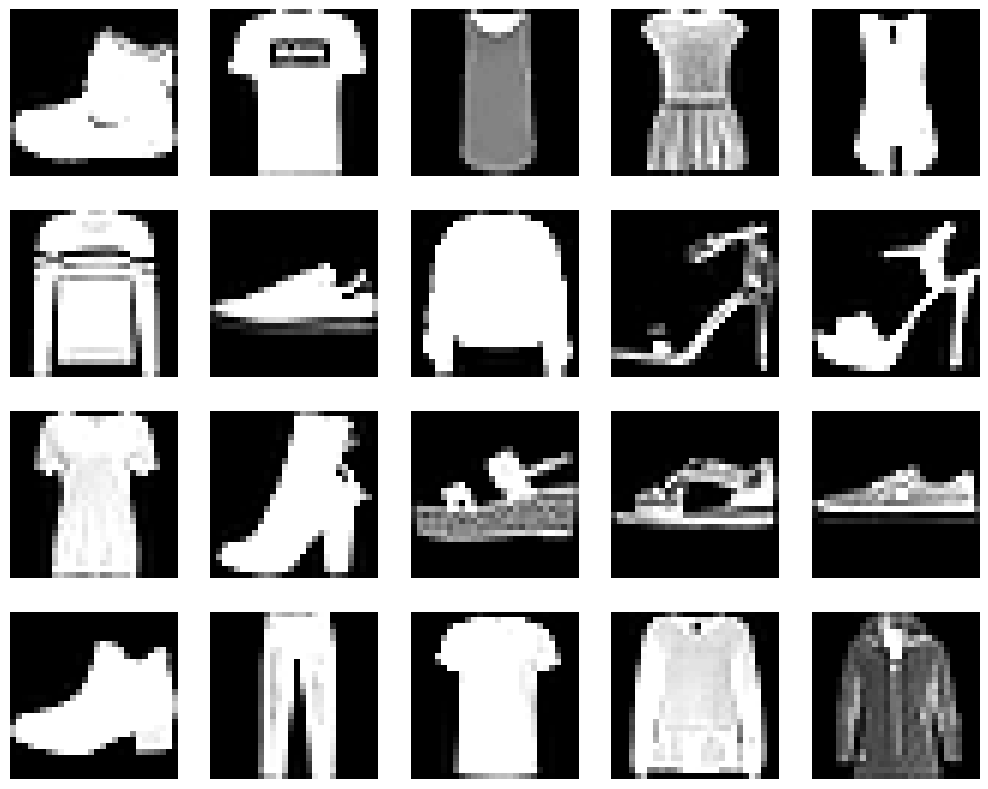

In [19]:
images = torch.cat([dataset[i][0] for i in range(20)]).unsqueeze(1)

translation_factor = 0
scale_factor = 2 * 2 / 28

# t = tns.RandomAffine(0, 
#                  translate=(translation_factor, translation_factor), 
#                  scale=(1 + scale_factor, 1 + scale_factor)
#                 )

f = 1.5
t = tns.ColorJitter(brightness=(f, f))

plot_images(t(images))

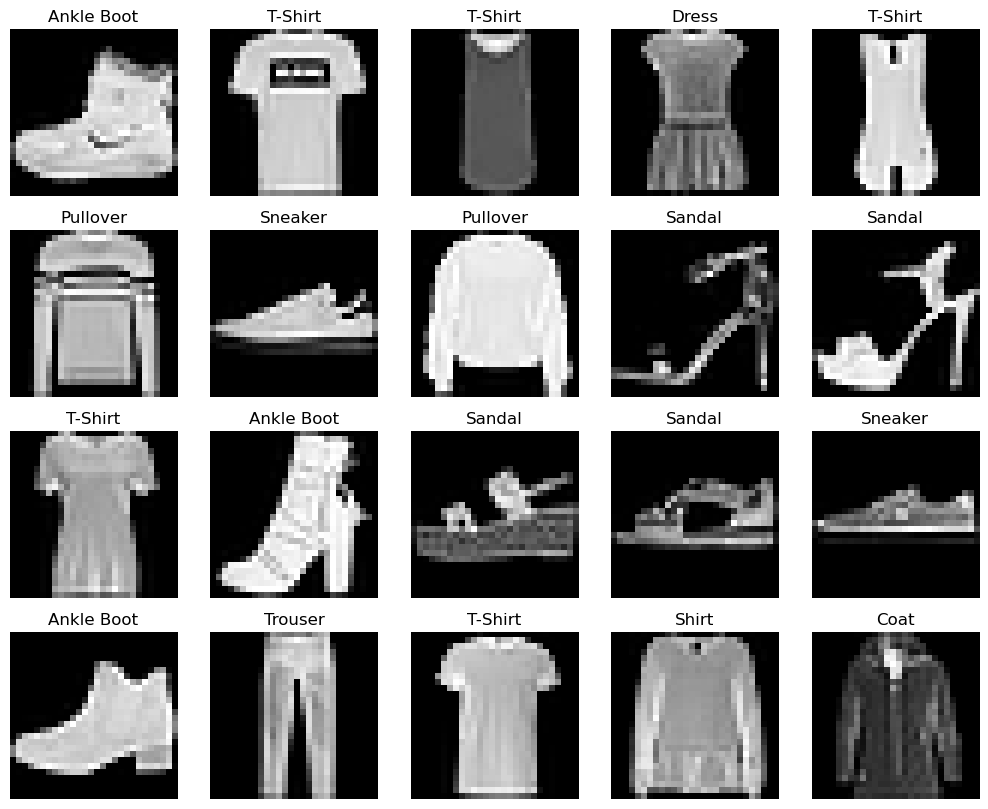

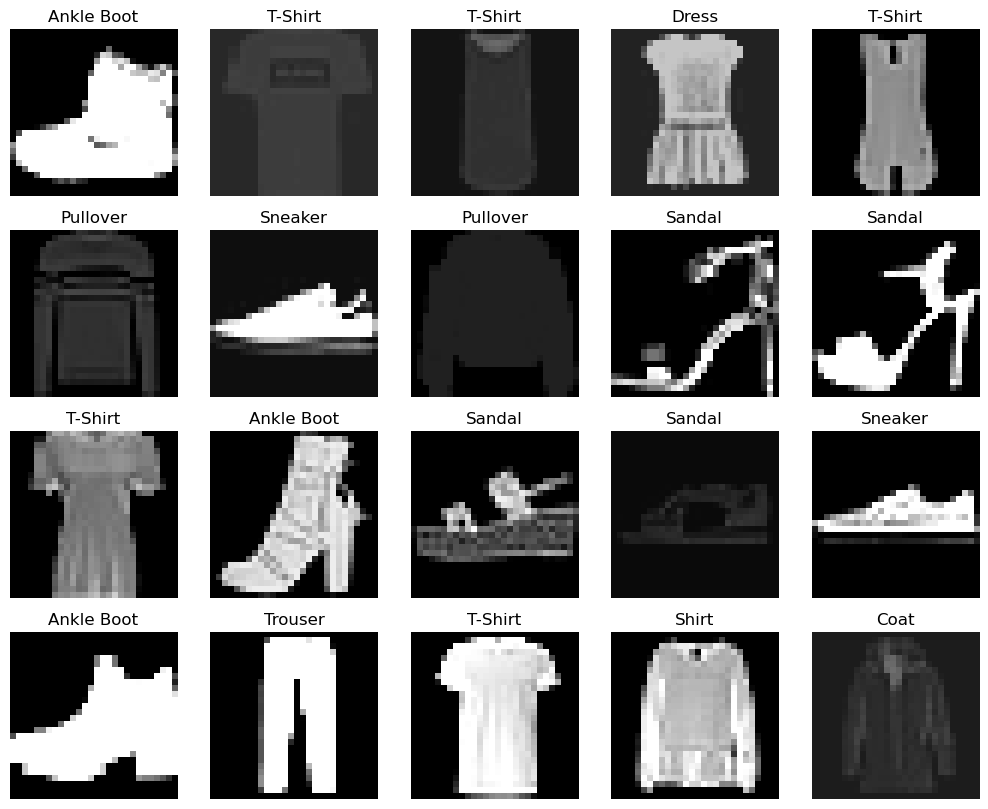

In [73]:
from typing import Callable

class GaussianNoise(Callable):
    def __init__(self, max_std=0.1):
        self.max_std = max_std

    def __call__(self, tensor):
#         std = self.max_std * torch.rand(1, device=device)
        return torch.clip(tensor + self.max_std * torch.randn_like(tensor, device=device), 0, 1)

augmenting_factor = None
    
def augment(dataset, transform_fun, approximate_size_in_millions=None, factor=None, batch_size=64):
    if factor is None:
        factor = ceil(approximate_size_in_millions * 1e6 / len(dataset))
        global augmenting_factor
        augmenting_factor = factor
        
    size = len(dataset) * factor
    X, y = zip(*dataset)
    
    X_transformed = torch.cat(X * factor).unsqueeze(1).to(device)
    ids = torch.randperm(size, device=device)
    batches = ceil(size / batch_size)
    
    for b in range(batches):
        batch_start = b * batch_size
        batch_end = min(batch_start + batch_size, size)
        batch_ids = ids[batch_start:batch_end]
        X_transformed[batch_ids] = transform_fun(X_transformed[batch_ids])
    
    return list(zip(list(X_transformed.to('cpu')), y * factor))

color_jitter_factor = 1
translation_factor = 0
scale_factor = 0.1
noise = 0.01

transform = tns.Compose([
    tns.RandomAffine(0, translate=(translation_factor, translation_factor), scale=(1 - scale_factor, 1 + scale_factor)),
    tns.ColorJitter(brightness=color_jitter_factor, contrast=color_jitter_factor, saturation=color_jitter_factor, hue=0.5),
    # GaussianNoise(noise),
    tns.ColorJitter(brightness=(0.5, 1.5)
])

subset = [original_dataset[i] for i in range(20)]
# subset = [s for s in original_dataset if s[1] == 4][:24]

plot_dataset(subset)
plot_dataset(augment(subset, transform, factor=1, batch_size=1))

In [6]:
import time

size_in_millions = 4

start_time = time.time()
dataset = augment(ori, transform, size_in_millions)
elapsed_time = time.time() - start_time

print(f'Augmenting lasted {elapsed_time:.0f}s, new dataset has {len(dataset)} samples')

Augmenting lasted 74s, new dataset has 4002210 samples


In [8]:
val_size = 10000
train_eval_dataset_max_size = 100000

train_size = len(original_dataset) - val_size
train_dataset, val_dataset = td.random_split(original_dataset, [train_size, val_size])

print(f'Dataset has been split in the ratio of {train_size} : {val_size}')

Dataset has been split in the ratio of 60000 : 10000


In [8]:
reduced_train_size = 500000

if reduced_train_size is not None:
    reduced_train_dataset = td.Subset(train_dataset, range(reduced_train_size))
    print(f'Reduced training dataset with {reduced_train_size} samples has been created')
else:
    reduced_train_dataset = None

Reduced training dataset with 500000 samples has been created


In [18]:
!rm models/*
!ls models/

In [ ]:
def classify(output):
    return torch.argmax(output, dim=1)

def compute_accuracy(pred, y):
    return pred.eq(y).sum().item() / len(y)

def compute_error(pred, y):
    return pred.ne(y).sum().item() / len(y)

def load_model(model):
    model.load_state_dict(torch.load('model.pt'))

def number_of_parameters(model):
    n = 0
    for p in model.parameters():
        n += torch.prod(torch.as_tensor(p.size()))
    return n

In [14]:
# add github versioning
# read more about architectures for image recognition and generalization
# read videni robotu slides

import torch.nn as nn

kernel_size = 3
conv1_filters = 8
conv2_filters = 16
linear2 = 100

massive_dropout = 0.5
ligth_dropout = 0.1

linear1 = (image_width * image_height) // (4 ** 2) * conv2_filters

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(image_channels, conv1_filters, kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(conv1_filters),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Dropout(ligth_dropout),
            nn.Conv2d(conv1_filters, conv2_filters, kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(conv2_filters),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Flatten(start_dim=1),
            nn.Dropout(massive_dropout),
            nn.Linear(linear1, linear2),
            nn.BatchNorm1d(linear2),
            nn.ReLU(),

            nn.Dropout(ligth_dropout),
            nn.Linear(linear2, n_classes),
            nn.BatchNorm1d(n_classes),

            nn.LogSoftmax(dim=1)
        )

    def forward(self, X):
        return self.sequential(X)
    
def train(model, train_dataset, val_dataset=None, epochs=None, batch_size=512, save=False, verbose=False):
    train_loader = td.DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = td.DataLoader(val_dataset, batch_size)
    
    if epochs is None:
        epochs = 1000000
    
    loss_fun = nn.NLLLoss()
    optimizer = torch.optim.AdamW(model.parameters(), 1e-3, weight_decay=0.05)
    # optimizer = torch.optim.Adam(model.parameters(), 0.01, weight_decay=0.002)
    # optimizer = torch.optim.SGD(model.parameters(), 0.001, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-2, epochs=epochs, steps_per_epoch=len(train_loader))
    
    train_eval_max_batches = min(train_eval_dataset_max_size // batch_size, len(train_loader))
    start_time = time.time()
    
    for epoch in range(1, 1 + epochs):
        model.train()
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fun(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            scheduler.step()
        
        if verbose:
            with torch.no_grad():
                model.eval()
                train_error, train_loss = 0, 0
                val_error, val_loss = 0, 0
                
                for b, (X, y) in enumerate(train_loader):
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    train_loss += loss_fun(pred, y)
                    train_error += compute_error(classify(pred), y)
                    
                    if b + 1 >= train_eval_max_batches:
                        break
                
                train_loss /= train_eval_max_batches
                train_error /= train_eval_max_batches
                
                if val_dataset is not None:
                    for X, y in val_loader:
                        X, y = X.to(device), y.to(device)
                        pred = model(X)
                        val_loss += loss_fun(pred, y)
                        val_error += compute_error(classify(pred), y)
                        
                    val_loss /= len(val_loader)
                    val_error /= len(val_loader)
                    
                    print(f'{epoch:2d} - error: {train_error:.3f}/{val_error:.3f} - loss: {train_loss:.3f}/{val_loss:.3f}', end='')
                else:
                    print(f'{epoch:2d} - error: {train_error:.3f} - loss: {train_loss:.3f}', end='')
                
            elapsed_time = time.time() - start_time
            print(f' - elapsed time: {elapsed_time:3.0f}s')
    
        if save:
            torch.save(model.state_dict(), 'models/model_e' + str(epoch) + '.pt')
  
mynet = MyNet().to(device)
print(f'MyNet with {number_of_parameters(MyNet())} parameters has been defined\n')
train(mynet, train_dataset, val_dataset, save=True, verbose=True)

MyNet with 52310 parameters has been defined

 1 - error: 0.248/0.247 - loss: 0.935/0.934 - elapsed time:  39s


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

save_stats = True
dataset_to_analyze = dataset

In [ ]:
plot_size = 3

conv_filters = list(mynet.parameters())[0].squeeze().to(cpu).detach()
n = len(conv_filters)

figure = plt.figure(figsize=(n * plot_size, plot_size))
plt.title('Learned convolution filters (the first convolutional layer)')
plt.axis("off")

for i, cf in enumerate(conv_filters):
    figure.add_subplot(1, n, i + 1)
    plt.axis("off")
    plt.imshow(cf, cmap='gray')

if save_stats:
    plt.savefig('learned_filters')
plt.show()

In [ ]:
plot_scale = 1.5
sns.set(font_scale=1)

def get_ground_truth_and_predictions(dataset, batch_size = 1024):
    n = len(dataset)
    y = torch.Tensor(n)
    pred = torch.Tensor(n)

    for b, (X, y_local) in enumerate(td.DataLoader(dataset, batch_size)):
        start = b * batch_size
        end = min(start + batch_size, n)
        pred[start:end] = classify(mynet(X.to(device)))
        y[start:end] = y_local
    
    return y, pred.to(cpu)

y, pred = get_ground_truth_and_predictions(dataset_to_analyze)
cm = confusion_matrix(pred, y)
error = np.sum(cm, 1) - np.diagonal(cm)
labels = list(label_map.values())
df = pd.DataFrame(error, index=labels, columns=['Error']).T

plt.figure(figsize=(n_classes * plot_scale, 1.5 * plot_scale))
sns.heatmap(df, annot=True, fmt='d', cbar=False, square=True, yticklabels=False).set_title('Misclassified samples')
if save_stats:
    plt.savefig('misclassified_samples')

In [ ]:
plot_size = 10

cm_copy = np.copy(cm)
np.fill_diagonal(cm_copy, 0)
vmax = np.max(cm_copy)
df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(plot_size, plot_size))
sns.heatmap(df, vmax=vmax, annot=True, fmt='d', cbar=False, square=True).set(xlabel='Predicted label', ylabel='Ground truth')
plt.yticks(rotation=0)
if save_stats:
    plt.savefig('confusion_matrix')
plt.show()

In [ ]:
def plot_misclassified(ground_truth, predicted_label, start_idx, n):
    mask = torch.logical_and(y == label_map_reverse(ground_truth), pred == label_map_reverse(predicted_label))
    indices = mask.nonzero()
    subset = [dataset_to_analyze[i] for i in indices][start_idx:start_idx + n]
    print(f'\'{ground_truth}\' classified as \'{pred_label}\'')
    plot_dataset(subset)
    
# plot_misclassified('T-Shirt', 'Shirt', 5000, 48)
# plot_misclassified('Shirt', 'T-Shirt', 0, 48)

In [ ]:
save_misclassified = False
min_misclassification = 0.5

if save_misclassified and len(extended_dataset) == len(original_dataset):
    y, pred = get_ground_truth_and_predictions(dataset_to_analyze)
    mask = y != pred
    misclassifications = torch.sum(mask.reshape(-1, len(original_dataset)), 0)

    for u, c in zip(*torch.unique(misclassifications, return_counts=True)):
        print(f'{u:2d} {c:5d}')
    
    indices = (misclassifications >= min_misclassification * augmenting_factor).nonzero().squeeze()
    torch.save(indices, path_misclassified_indices)
    print(f'{len(indices)} indices have been saved')